In [2]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [52]:
def mi_event_parsing(miinfofile):
    def nr_pci_track():
        if miinfofile.loc[i, "PCI"] == 65535: ## 65535 is for samgsung phone.
            nr_pci = '-'
        else:
            nr_pci = miinfofile.loc[i, "PCI"]
        return nr_pci

    nr_pci = None ## Initial Unknown
     
    lte_4G_handover_list = []   #4G 狀態下LTE eNB 的 handover
    
    nr_setup_list = []          #gNB cell addition
    nr_handover_list = []       #gNB cell changes (eNB stays the same)
    nr_removal_list = []        #gNB cell removal
        
    lte_5G_handover_list = []   #(eNB1, gNB1) -> (eNB2, gNB1) #gNB stays the same
    nr_lte_handover_list = []   #both NR cell and LTE cell have handover
    
    eNB_to_MN_list = []
    MN_to_eNB_list = []
    
    scg_failure_list = []       #gNB handover failure
    reestablish_list_type2 = [] #eNB handover failure
    reestablish_list_type3 = []
    
    SCell_rel = []
    SCell_add = []
    SCell_add_rel = []

    nr_handover = 0
    nr_handover_start_index = None
    lte_handover = 0
    lte_handover_start_index = None
    nr_release = 0
    nr_release_start_index = None
    
    lte_failure = 0
    lte_failure_start_index = None
    
    handover_num = 0
    
    for i in range(len(miinfofile)):
        if miinfofile.loc[i, "type_id"] == "5G_NR_RRC_OTA_Packet":
            nr_pci = nr_pci_track()
            continue
            
        if miinfofile.loc[i, "nr-rrc.t304"]:
            if nr_handover == 0:    
                nr_handover = 1
                nr_handover_start_index = i
                
        if miinfofile.loc[i, "lte-rrc.t304"]:
            if lte_handover == 0:
                lte_handover = 1
                lte_handover_start_index = i
                
        if miinfofile.loc[i, "nr-Config-r15: release (0)"]:
            if nr_release == 0:
                nr_release = 1
                nr_release_start_index = i
           
        if (nr_handover or lte_handover or nr_release) and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            handover_num +=1
        
        
        #handover 種類分類
        #------------------------------------------------------------------------------
        if lte_handover and not nr_handover and not nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just lte cell handover event
            lte_handover = 0
            lte_4G_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            

        if lte_handover and not nr_handover and nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:    # LTE Ho and nr release 
            lte_handover = 0
            nr_release = 0
            MN_to_eNB_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
        
        if nr_handover and not lte_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just nr cell handover event
            nr_handover = 0
            if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                nr_setup_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])       
            else:
                nr_handover_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            #additional judgement:
            #----------------------------
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"] and nr_pci != None:
            #    print("Warning: dualConnectivityPHR setup may not mean nr cell addition", mi_file, i)
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]==0 and not (nr_pci != None and nr_pci != miinfofile.loc[nr_handover_start_index, "nr_pci"]): 
            #    print("Warning: nr-rrc.t304 without dualConnectivityPHR setup may not mean nr cell handover", mi_file, i, nr_handover_start_index, miinfofile.loc[nr_handover_start_index, "nr_pci"], nr_pci)
                
        if lte_handover and nr_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:      # both nr cell and lte cell handover event
            lte_handover = 0
            nr_handover = 0
            if nr_pci == miinfofile.loc[lte_handover_start_index, "nr_physCellId"]: 
                lte_5G_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            else:
                ##############
                if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                    eNB_to_MN_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])       
                else:
                    nr_lte_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            
        if not lte_handover and  nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            nr_release=0
            nr_removal_list.append([miinfofile.loc[nr_release_start_index, "time"], miinfofile.loc[i, "time"]])
            
        if miinfofile.loc[i, "scgFailureInformationNR-r15"]:
            scg_failure_list.append([miinfofile.loc[i, "time"], miinfofile.loc[i, "time"]]) 
            
        if miinfofile.loc[i, "rrcConnectionReestablishmentRequest"]:
            if lte_failure == 0:
                lte_failure = 1
                lte_failure_start_index = i
        if lte_failure and miinfofile.loc[i, "rrcConnectionReestablishment"]:
            lte_failure = 0
            reestablish_list_type2.append([miinfofile.loc[lte_failure_start_index, "time"], miinfofile.loc[lte_failure_start_index, "time"]])
        if lte_failure and miinfofile.loc[i, "rrcConnectionReestablishmentReject"]:
            lte_failure = 0
            reestablish_list_type3.append([miinfofile.loc[lte_failure_start_index, "time"], miinfofile.loc[lte_failure_start_index, "time"]])
        
        if (miinfofile.loc[i, "sCellToReleaseList-r10"] != '0' and miinfofile.loc[i, "sCellToReleaseList-r10"] != 0):
            SCell_rel.append([miinfofile.loc[i, "time"]])
        
        if miinfofile.loc[i, "SCellToAddMod-r10"] and miinfofile.loc[i, "SCellIndex-r10.1"] != 'nr or cqi report':
            SCell_add.append([miinfofile.loc[i, "time"]])

        if (miinfofile.loc[i, "sCellToReleaseList-r10"] != '0'and miinfofile.loc[i, "sCellToReleaseList-r10"] != 0) and miinfofile.loc[i, "SCellToAddMod-r10"] and miinfofile.loc[i, "SCellIndex-r10.1"] != 'nr or cqi report':
            SCell_add_rel.append([miinfofile.loc[i, "time"], miinfofile.loc[i, "time"]])


    return [lte_4G_handover_list, nr_setup_list, nr_handover_list, nr_removal_list, lte_5G_handover_list, nr_lte_handover_list, eNB_to_MN_list, MN_to_eNB_list, scg_failure_list, 
    reestablish_list_type2, reestablish_list_type3, SCell_rel, SCell_add, SCell_add_rel], handover_num

def collect_ho_event(mi_rrc_df):
    l, _ = mi_event_parsing(mi_rrc_df)
    for i in range(len(l)):
        l[i] = [j[0] for j in l[i]]
    d = {'lte': l[0], 'nr_setup': l[1], 'gNB_ho': l[2], 'nr_rel': l[3], "MN_changed": l[4],"MN_SN_changed": l[5],
     "eNB to MN changed": l[6], "MN to eNB changed": l[7], "gNB fail": l[8], "type2 fail": l[9], "type3 fail": l[10], 
     'SCell_rel': l[11], 'SCell_add': l[12], 'SCell_add_rel': l[13]}
    return d

In [180]:
dir = "/home/wmnlab/Code_Test_Space/sheng-ru/2022-09-29/_Bandlock_Udp"
trace = ['#03']
file = ["dwnlnk_udp_latency.csv", "uplnk_udp_latency.csv", "dwnlnk_udp_loss_timestamp.csv","uplnk_udp_loss_timestamp.csv", ]
DL_latency_files = []
UL_latency_files = []
DL_loss_files = []
UL_loss_files = []
rrc_files = []

for a in sorted(os.listdir(dir)):
    d0 = os.path.join(dir, a)
    # print(d0)
    for b in sorted(os.listdir(d0)):
        if b in trace:
            d1 = os.path.join(d0, b, 'analysis', file[0])
            d2 = os.path.join(d0, b, 'analysis', file[1])
            d3 = os.path.join(d0, b, 'analysis', file[2])
            d4 = os.path.join(d0, b, 'analysis', file[3])
            d00 = os.path.join(d0, b, 'data')
            for c in sorted(os.listdir(d00)):
                if c.endswith('txt_rrc.csv'):
                    d5 = os.path.join(d00, c)
            DL_latency_files.append(d1)
            UL_latency_files.append(d2)
            DL_loss_files.append(d3)
            UL_loss_files.append(d4)
            rrc_files.append(d5)

In [181]:
DL_latency_dfs = []
for csv in DL_latency_files:
    df = pd.read_csv(csv)
    df["Timestamp"] = df["Timestamp"].apply(lambda x: pd.to_datetime(x))
    DL_latency_dfs.append(df)

In [182]:
UL_latency_dfs = []
for csv in UL_latency_files:
    df = pd.read_csv(csv)
    df["Timestamp"] = df["Timestamp"].apply(lambda x: pd.to_datetime(x))
    UL_latency_dfs.append(df)

In [183]:
DL_loss_dfs = []
for csv in DL_loss_files:
    df = pd.read_csv(csv)
    df["Timestamp"] = df["Timestamp"].apply(lambda x: pd.to_datetime(x))
    DL_loss_dfs.append(df)

In [184]:
UL_loss_dfs = []
for csv in UL_loss_files:
    df = pd.read_csv(csv)
    df["Timestamp"] = df["Timestamp"].apply(lambda x: pd.to_datetime(x))
    UL_loss_dfs.append(df)

In [185]:
rrc_dfs = []
for csv in rrc_files:
    df = pd.read_csv(csv)
    df["time"] = df["time"].apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    rrc_dfs.append(df)

In [186]:
rrc_files

['/home/wmnlab/Code_Test_Space/sheng-ru/2022-09-29/_Bandlock_Udp/sm05/#03/data/diag_log_sm05_2022-09-29_16-37-51.txt_rrc.csv',
 '/home/wmnlab/Code_Test_Space/sheng-ru/2022-09-29/_Bandlock_Udp/sm06/#03/data/diag_log_sm06_2022-09-29_16-37-51.txt_rrc.csv',
 '/home/wmnlab/Code_Test_Space/sheng-ru/2022-09-29/_Bandlock_Udp/sm07/#03/data/diag_log_sm07_2022-09-29_16-37-51.txt_rrc.csv',
 '/home/wmnlab/Code_Test_Space/sheng-ru/2022-09-29/_Bandlock_Udp/sm08/#03/data/diag_log_sm08_2022-09-29_16-37-51.txt_rrc.csv']

In [189]:
HO_events = []
for df in rrc_dfs:
    x = collect_ho_event(df)
    HO_events.append(x)

In [190]:
HO_events[0].keys()

dict_keys(['lte', 'nr_setup', 'gNB_ho', 'nr_rel', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail', 'SCell_rel', 'SCell_add', 'SCell_add_rel'])

Text(0.5, 0.98, 'DL latency')

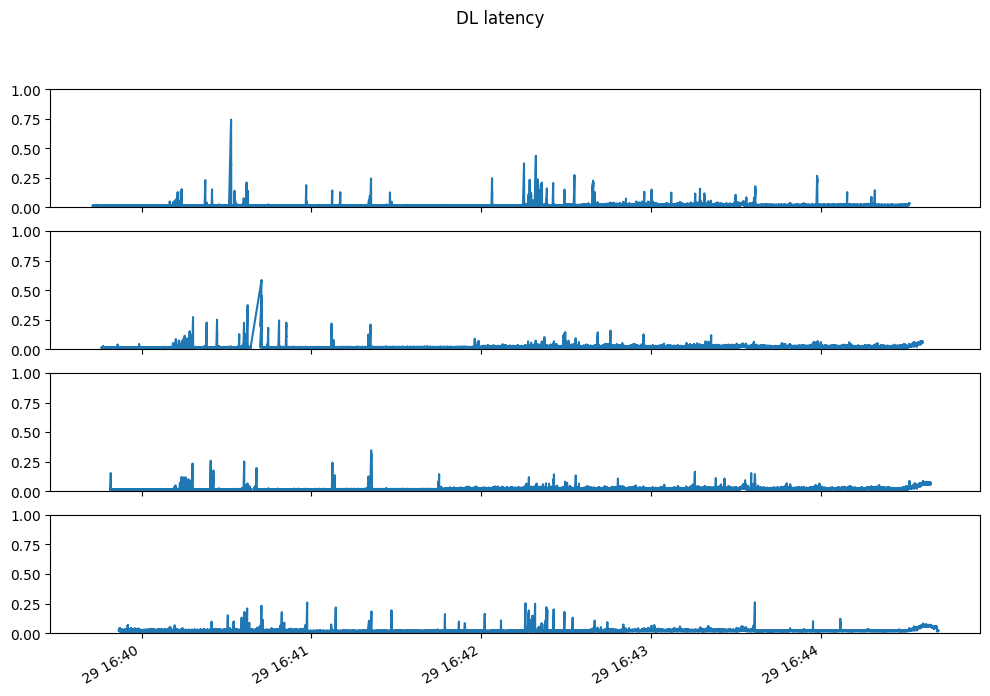

In [191]:
fig, axs = plt.subplots(4,1, figsize=(12, 8), sharex=True)
plt.gcf().autofmt_xdate()

for (i, df), df2 in zip(enumerate(DL_latency_dfs), DL_loss_dfs):
    x = df["Timestamp"].iloc[:]
    y = df["latency"].iloc[:]
    axs[i].plot(x, y)
    axs[i].set_ylim([0, 1])

    x2 = df2["Timestamp"].iloc[:]
    # axs[i].vlines(x2,ymin=0, ymax=1, color='r', label='loss')

left, right = axs[0].get_xlim()
plot = []
# plot = ['lte', 'MN_changed', 'type3 fail']
# plot = ['nr_setup', 'gNB_ho', 'nr_rel', 'gNB']
# plot = ['SCell_add_rel']
color = ['g', 'm', 'yellow', 'k', 'c', 'orange', 'purple', 'cyan', 'olive', 'peru', 'navy', 'slategray', 'chocolate','black']
for i, A in enumerate(HO_events):
    for j, event in enumerate(A):
        if event in plot:
            x = A[event]
            axs[i].vlines(x,ymin=0, ymax=1, color=color[j],label=event)
    axs[i].set_xlim([left, right])
    if len(plot) != 0:
        axs[i].legend()
fig.suptitle('DL latency')

In [192]:
HO_events[0].keys()

dict_keys(['lte', 'nr_setup', 'gNB_ho', 'nr_rel', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail', 'SCell_rel', 'SCell_add', 'SCell_add_rel'])

Text(0.5, 0.98, 'UL latency')

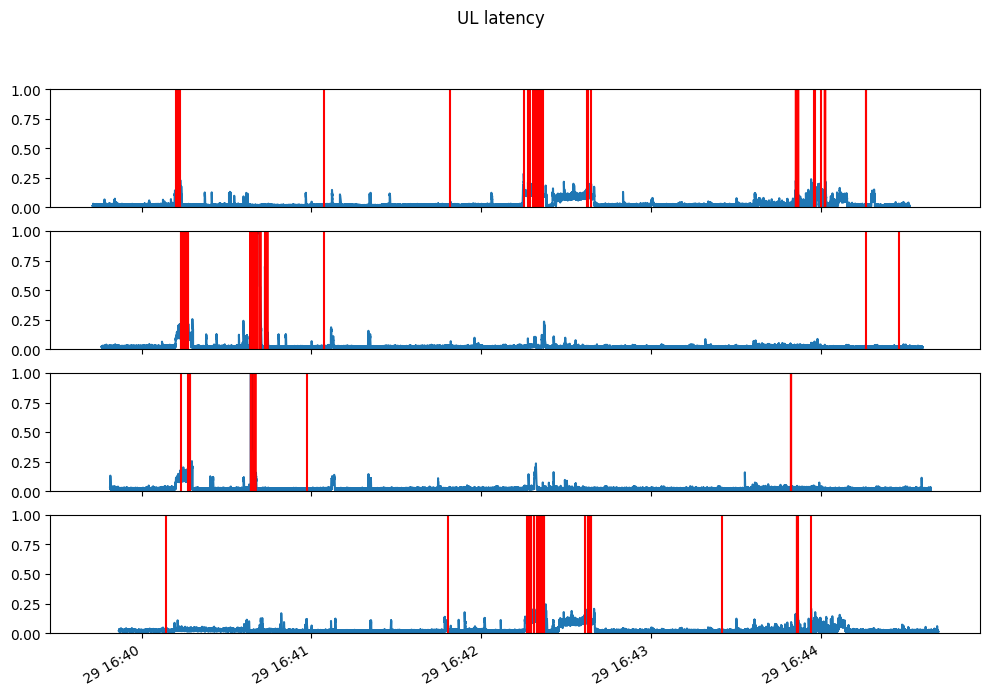

In [195]:
fig, axs = plt.subplots(4,1, figsize=(12, 8), sharex=True)
plt.gcf().autofmt_xdate()

for (i, df), df2 in zip(enumerate(UL_latency_dfs), UL_loss_dfs):
    x = df["Timestamp"].iloc[:]
    y = df["latency"].iloc[:]
    axs[i].plot(x, y)
    axs[i].set_ylim([0, 1])

    x2 = df2["Timestamp"].iloc[:]
    axs[i].vlines(x2,ymin=0, ymax=1, color='r')

left, right = axs[0].get_xlim()
plot = []
# plot = ['lte', 'MN_changed', 'type3 fail']
# plot = ['nr_setup', 'gNB_ho', 'nr_rel', 'gNB']
# plot = ['SCell_add_rel']
color = ['g', 'm', 'yellow', 'k', 'c', 'orange', 'purple', 'cyan', 'olive', 'peru', 'navy', 'slategray', 'chocolate','black']
for i, A in enumerate(HO_events):
    for j, event in enumerate(A):
        if event in plot:
            x = A[event]
            axs[i].vlines(x,ymin=0, ymax=1, color=color[j],label=event)
    axs[i].set_xlim([left, right])
    if len(plot) != 0:
        axs[i].legend()
fig.suptitle('UL latency')

<Figure size 1200x800 with 0 Axes>

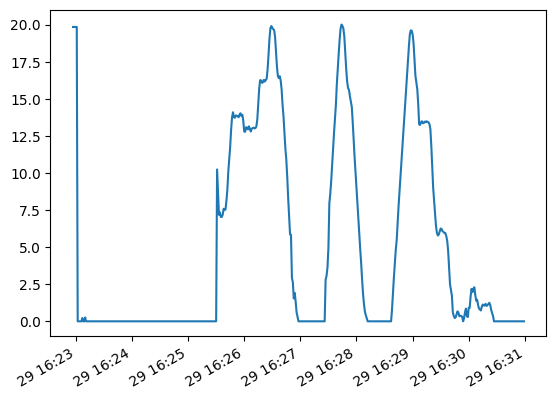

<Figure size 1200x800 with 0 Axes>

In [127]:
f = '/home/wmnlab/123456.csv'
df = pd.read_csv(f)
df["time"] = df["time"].apply(lambda x: pd.to_datetime(x))
plt.plot(df["time"], df[" GPSSpeed"])
plt.gcf().autofmt_xdate()
plt.figure(figsize=(12,8))